In [ ]:
!apt -qq -y install fonts-nanum > /dev/null
 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
 
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
 
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/My Drive/chung_proj/선유도예측

/content/gdrive/My Drive/chung_proj/선유도예측


# 선유도 관광객 데이터(2005년-2020년) 전처리

In [ ]:
sun_u = pd.read_excel('선유도관광객.xls')
sun_u = sun_u.transpose()
sun_u.head(10)

,0,1,2
시도,NaN,전라북도,전라북도
군구,NaN,군산시,군산시
관광지,NaN,선유도,선유도
내/외국인,NaN,내국인,합계
총계(2005.01 ~ 2021.01),NaN,1.49681e+07,1.49681e+07
2005년,인원계,195803,195803
Unnamed: 6,2005년 01월,2851,2851
Unnamed: 7,2005년 02월,5222,5222
Unnamed: 8,2005년 03월,7967,7967
Unnamed: 9,2005년 04월,9585,9585


In [ ]:
sun_u = sun_u.reset_index()
sun_u.drop(['index'],axis=1,inplace=True)
sun_u.drop([sun_u.index[0],sun_u.index[1],sun_u.index[2],sun_u.index[3],sun_u.index[4],sun_u.index[5]],inplace=True)

In [ ]:
sun_u['관광객 수'] =sun_u[2]
sun_u.drop([sun_u.columns[2],sun_u.columns[1]],axis=1,inplace=True)
sun_u.reset_index(inplace=True)
sun_u.drop(['index'],axis=1,inplace=True)
sun_u['월별'] =sun_u[0]
sun_u.drop(sun_u.columns[0],axis =1,inplace=True)
sun_u

,관광객 수,월별
0,2851,2005년 01월
1,5222,2005년 02월
2,7967,2005년 03월
3,9585,2005년 04월
4,7891,2005년 05월
...,...,...
204,322677,2020년 10월
205,185540,2020년 11월
206,157135,2020년 12월
207,146827,인원계


In [ ]:
sun_u = sun_u[~sun_u['월별'].str.contains("인원계")]
sun_u = sun_u[~sun_u['월별'].str.contains("2021년 01월")]

count = sun_u.reset_index(drop= True)
count = count.rename(columns={'월별':'ds', '관광객 수':'y'})
count

,y,ds
0,2851,2005년 01월
1,5222,2005년 02월
2,7967,2005년 03월
3,9585,2005년 04월
4,7891,2005년 05월
...,...,...
187,339415,2020년 08월
188,325477,2020년 09월
189,322677,2020년 10월
190,185540,2020년 11월


#  Prophet model 이용해서 관광객 수 예측하기

In [ ]:
from fbprophet import Prophet 

model = Prophet()

ds 데이터 타입을 date-time 형태로 변환해주기

In [ ]:
count = count[['ds','y']]

count['ds'] = count['ds'].str.replace('년 ', '-')
count['ds'] = count['ds'].str.replace('월', '')
count['ds'] =count['ds'] + "-01"

count

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,ds,y
0,2005-01-01,2851
1,2005-02-01,5222
2,2005-03-01,7967
3,2005-04-01,9585
4,2005-05-01,7891
...,...,...
187,2020-08-01,339415
188,2020-09-01,325477
189,2020-10-01,322677
190,2020-11-01,185540


#parameter 조정



In [ ]:
# parameter 튜닝
# 전후로 변화하는 트렌드를 반영하기 위해서 change points를 따로 넣어줌(코로나 시작점, 다리 완공시점)
# 월별 데이터이기 때문에 weekly와 daily seasonality는 False로 설정해줌!

import fbprophet as Prophet

model2 =  Prophet.Prophet(changepoint_prior_scale=0.5, changepoints = ['2020-01-25','2013-12-01'],yearly_seasonality='auto',weekly_seasonality=False,daily_seasonality=False, growth='linear') 
model2.fit(count);
past = model2.make_future_dataframe(periods=0, freq='M')
future_data = pd.DataFrame(['2021-01-01','2021-02-01','2021-03-01','2021-04-01','2021-05-01','2021-06-01','2021-07-01','2021-08-01','2021-09-01','2021-10-01','2021-11-01','2021-12-01','2022-01-01','2022-02-01','2022-03-01','2022-04-01','2022-05-01','2022-06-01','2022-07-01','2022-08-01','2022-09-01','2022-10-01','2022-11-01','2022-12-01'], columns=['ds']).astype( 'datetime64[ns]')
future_data = pd.concat([past,future_data],axis=0)
forecast_data = model2.predict(future_data)

Text(0.5, 1.0, '선유도 관광객의 추이와 예측')

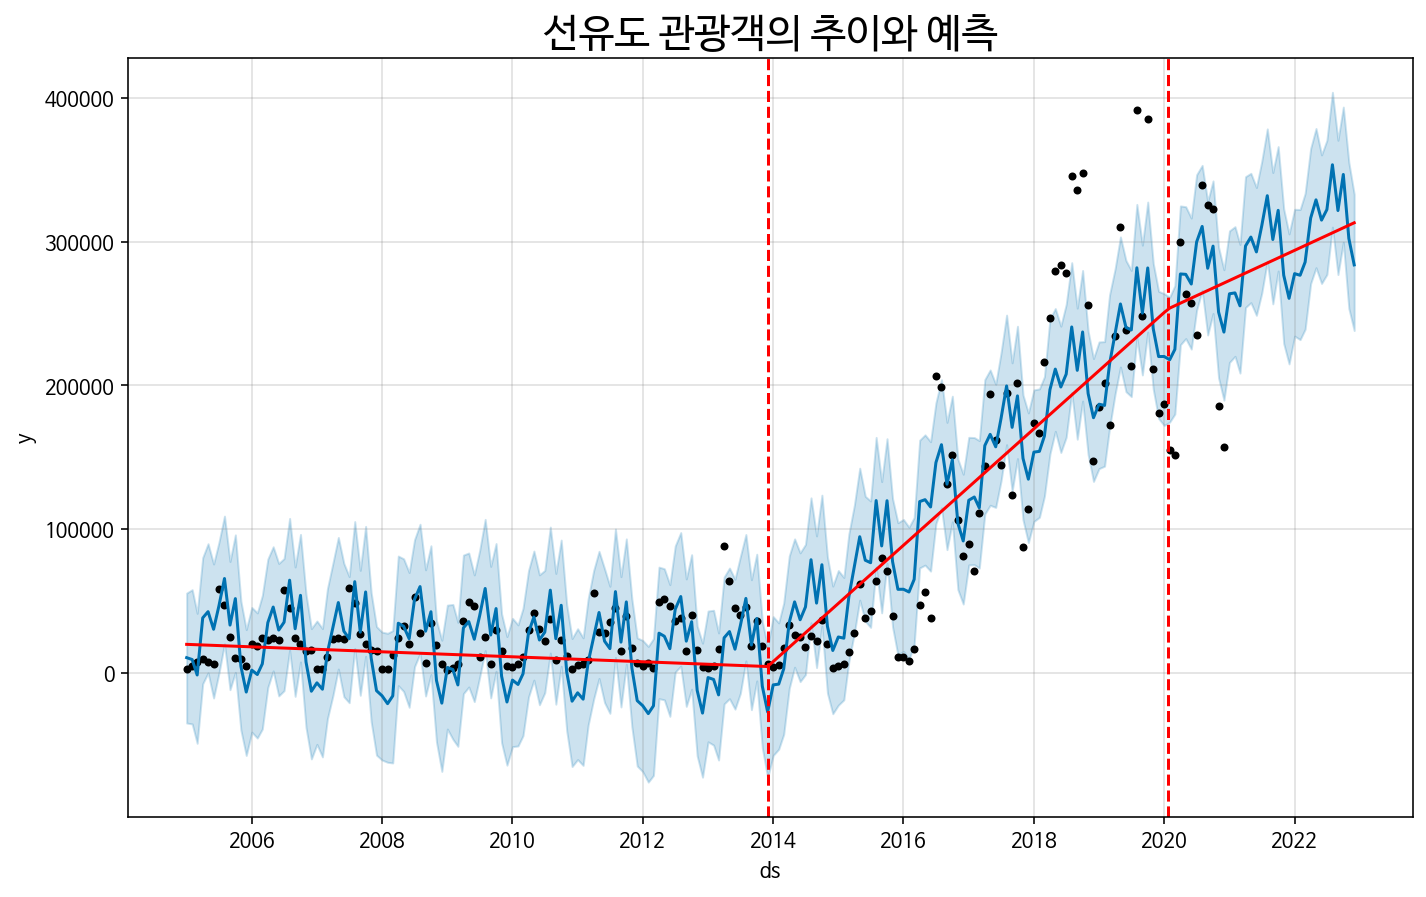

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
fig = model2.plot(forecast_data)
a = add_changepoints_to_plot(fig.gca(), model2, forecast_data)
plt.title('선유도 관광객의 추이와 예측',fontsize=20)

빨간 실선 = 트렌드, 빨간 점선 = 트렌드가 변화하는 changepoint, 검은점 = 실제 데이터
육지와 고군산군도가 연결된 다리가 완공된 2013년 말이 changepoint가 되어서 관광객이 계속해서 증가하는 trend를 보여줌

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 8722 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 8722 missing from current font.



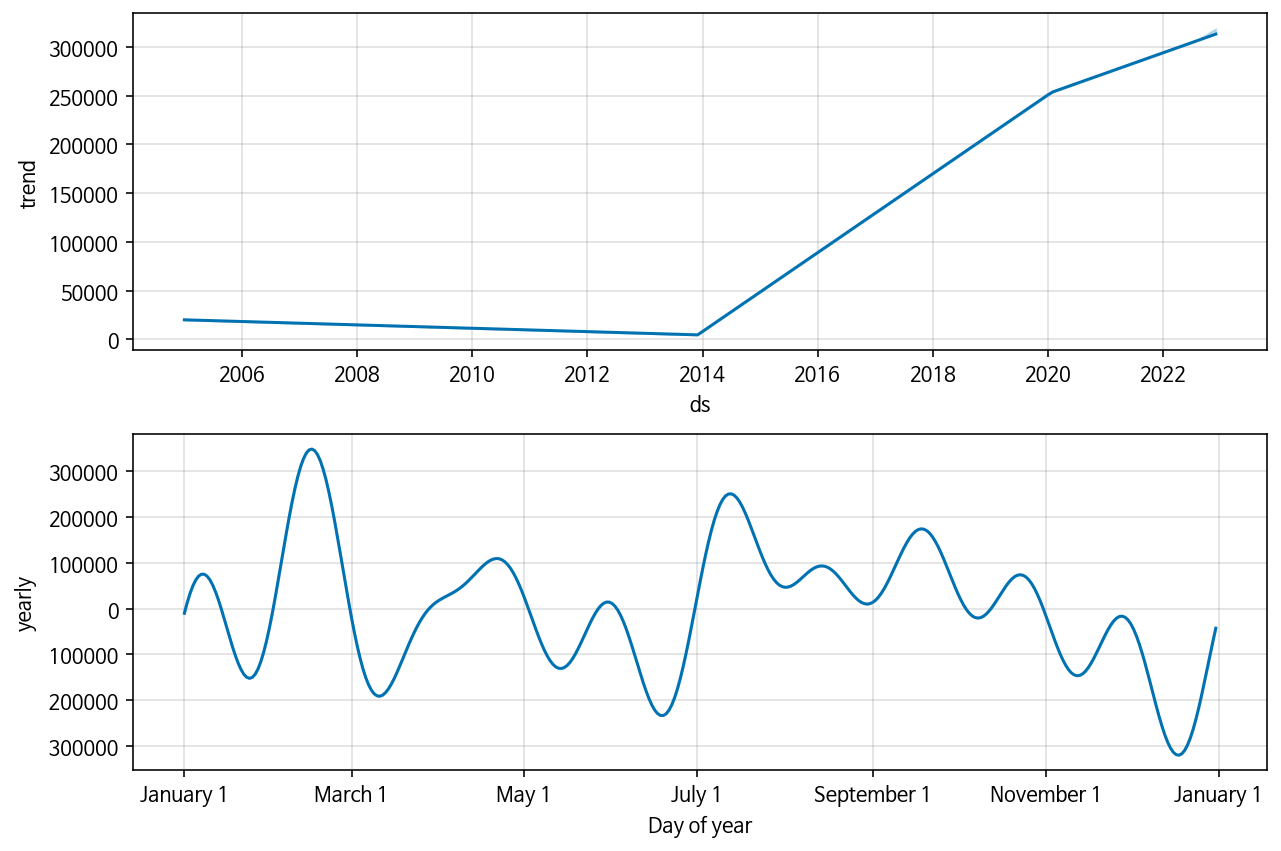

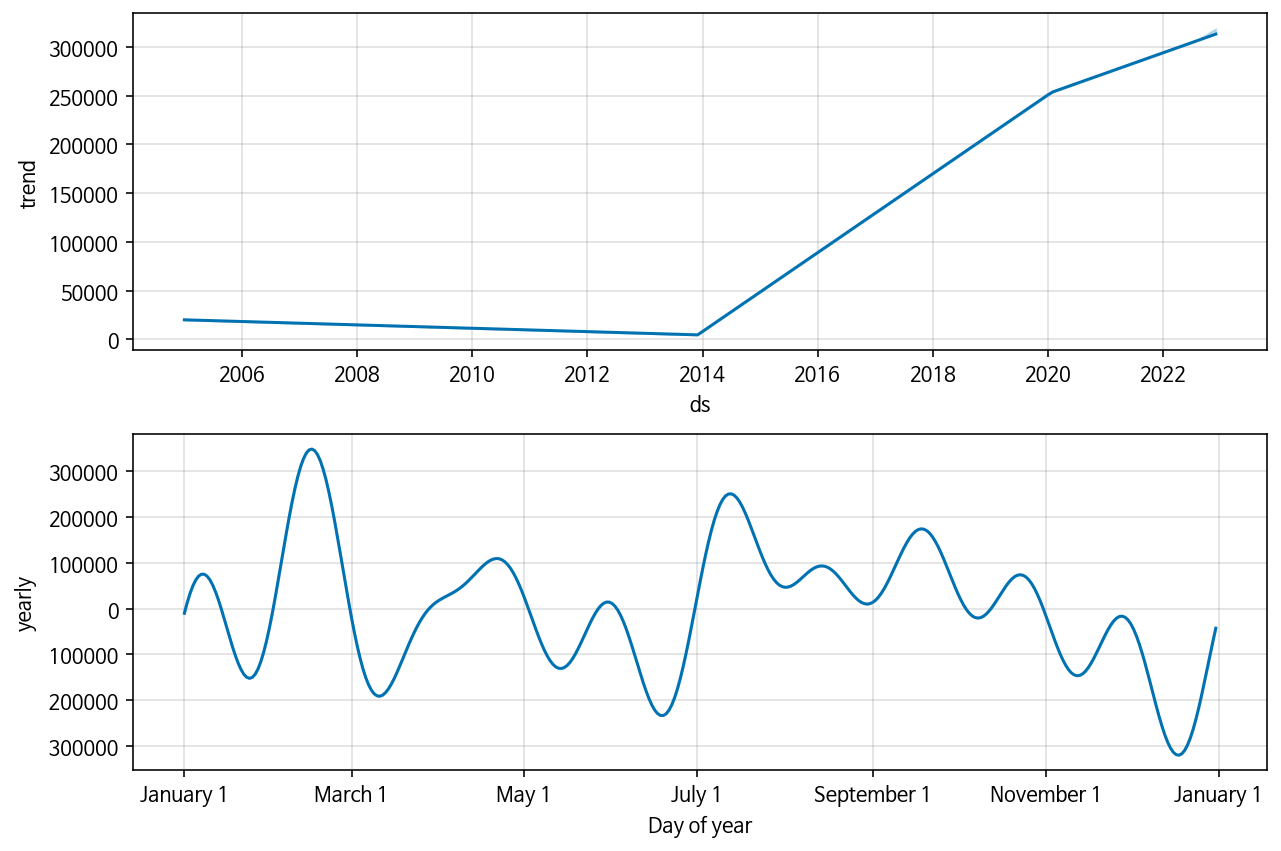

In [ ]:
model.plot_components(forecast_data)